In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

In [4]:
__file__ = 'C:/Users/antie/Documents/Pole_recherche/Tsunami'

In [3]:
__file__ = 'C:/Users/Gilles/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

In [4]:
import os

print(os.getcwd())
os.chdir(__file__)
print(os.getcwd())

c:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami\differentiate
C:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami


In [5]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

## Create the model

In [85]:
# To fix weights or biases of layers
class ConstantTensorInitializer(tf.keras.initializers.Initializer):
  """Initializes tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, shape, dtype=None):
    return self.t

  def get_config(self):
    # A constraint config is a Python dictionary (JSON-serializable) that can be used to reinstantiate the same object.
    return {'t': self.t}

class ConstantTensorConstraint(tf.keras.constraints.Constraint):
  """Constrains tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, w):
    return self.t

  def get_config(self):
    return {'t': self.t}


# t could be :
t = tf.ones((3,4))
print(t)

t1 = tf.eye(3,4)
print(t1)

tf.Tensor(
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]], shape=(3, 4), dtype=float32)


In [6]:
def generate_model(n_hidden=2,noise=False):
  # méthode API Sequential
  multilayer_perceptron = keras.models.Sequential([
    keras.layers.Input(shape=(2))
  ])
  if noise:
    multilayer_perceptron.add(keras.layers.GaussianNoise(stddev=1e-3))
  for _ in range(n_hidden):
        multilayer_perceptron.add(keras.layers.Dense(20,activation='elu', kernel_initializer='he_normal'))
  multilayer_perceptron.add(keras.layers.Dense(1,use_bias=False))
  multilayer_perceptron.summary()
  return multilayer_perceptron


In [34]:
# to check :
multilayer_perceptron = generate_model()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 20)                60        
                                                                 
 dense_31 (Dense)            (None, 20)                420       
                                                                 
 dense_32 (Dense)            (None, 1)                 20        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Given EDO
def f(X):
  return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])


def boundary_conditions(X):
  return 0


def residual(du_dxx,du_dyy,f_ind):
  return du_dxx+du_dyy+f_ind


def differentiate(model,x):
  with tf.GradientTape(persistent=True) as tape:
    x1, x2 = x[:,0:1], x[:,1:2]
    tape.watch(x1)
    tape.watch(x2)
    u = model(tf.stack([x1[:,0], x2[:,0]], axis=1))
    du_dx = tape.gradient(u,x1)
    du_dy = tape.gradient(u,x2)
  du_dxx = tape.gradient(du_dx,x1) 
  du_dyy = tape.gradient(du_dy,x2)
  return du_dx, du_dxx, du_dy, du_dyy


grid_length = 100


X = np.linspace(0,1,grid_length, endpoint=True)
Y = np.linspace(0,1,grid_length, endpoint=True)
tf_coords = tf.convert_to_tensor([tf.constant([x,y],dtype=DTYPE) for x in X for y in Y])
tf_boundary_coords = tf.convert_to_tensor([tf.constant([x,y],dtype=DTYPE) for x in [0,1] for y in Y ] + [tf.constant([x,y],dtype=DTYPE) for y in [0,1] for x in X ])  

#print(boundary_coords.shape)



## Method 1: mini-batch gradient descent with training to respect the boundary conditions at the same time of the one for the EDP

Papier : 2019_A_unified_deep_artificial_neural_network_approach_to_PDE_in_complex_geometries.pdf

In [7]:
# method 1: mini-batch gradient descent + (loss = MSE + MSE on all boundary) 

# a few train parameters to adjust
learning_rate = 0.01
training_steps = 200
batch_size = 1000
display_step = 100

alpha = 15 # magnify the boundary condition in the loss

optimizer = tf.optimizers.Adam(lr=learning_rate)

# generate model
multilayer_perceptron = generate_model()


# Universal Approximator
def g_1(x):
  # F_x = Pstud._eval_polynome_numpy(F_xpy_real,x[0,0],x[0,1])
  N_x = multilayer_perceptron(x)
  return N_x


# Custom loss function to approximate the derivatives

def custom_loss_1():
  indices = np.random.randint(tf_coords.shape[0],size=batch_size)
  tf_sample_coords = tf.convert_to_tensor([tf_coords[i] for i in indices])

  _,dg_dxx,_,dg_dyy = differentiate(g,tf_sample_coords)
  f_r = tf.reshape(f(tf_sample_coords),[batch_size,1])
  res = residual(dg_dxx,dg_dyy,f_r)

  loss = tf.reduce_mean(tf.square(res)) + alpha*tf.reduce_mean(tf.square(g(tf_boundary_coords)-boundary_conditions(tf_boundary_coords)))
  return loss

# train of method 1: 
def train_step_1():
  with tf.GradientTape() as tape:
    loss = custom_loss_1()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 20        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


C:\Users\Gilles\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
loss: tf.T

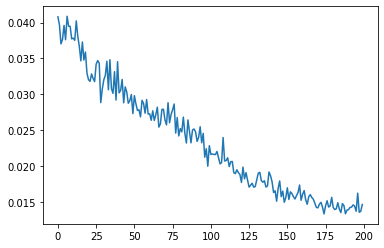

In [37]:
# Training the Model of method 1:

all_losses = []

for i in range(training_steps):
  print('epoch:',i)
  loss = train_step_1()
  if i % display_step == display_step-1:
    print("loss:", loss)
  all_losses.append(loss)

plt.plot(np.arange(0,training_steps),all_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Method 2: MBGD with pretraining to respect the boundary condition

In [10]:
# method 2 : pretrain before on the boundary condition and after inside the boundary

# a few train parameters to adjust
learning_rate = 0.01
training_steps_boundary = 30
training_steps_global = 20
batch_size = 1000
display_step_boundary = 10
display_step_global = 10

alpha=0 # magnify the boundary condition in custom_loss_2()

optimizer = tf.optimizers.Adam(lr=learning_rate)

# Universal Approximator
def g_2(x):
  # F_x = Pstud._eval_polynome_numpy(F_xpy_real,x[0,0],x[0,1])
  N_x = multilayer_perceptron(x)
  return N_x

# generate model
multilayer_perceptron = generate_model()

# Custom loss function to approximate the derivatives
def custom_loss_2_boundary():
  indices = np.random.randint(tf_boundary_coords.shape[0],size=batch_size)
  tf_sample_boundary_coords = tf.convert_to_tensor([tf_boundary_coords[i] for i in indices])

  loss = tf.reduce_mean(tf.square(g(tf_sample_boundary_coords)-boundary_conditions(tf_sample_boundary_coords)))
  # print('loss :', loss)
  return loss


def custom_loss_2():
  indices = np.random.randint(tf_coords.shape[0],size=batch_size)
  tf_sample_coords = tf.convert_to_tensor([tf_coords[i] for i in indices])

  _,dg_dxx,_,dg_dyy = differentiate(g,tf_sample_coords)
  f_r = tf.reshape(f(tf_sample_coords),[batch_size,1])
  res = residual(dg_dxx,dg_dyy,f_r)

  loss = tf.reduce_mean(tf.square(res)) + alpha*tf.reduce_mean(tf.square(g(tf_boundary_coords)-boundary_conditions(tf_boundary_coords)))
  return loss


# train of method 2:
def train_step_2_boundary():
  with tf.GradientTape() as tape:
    loss = custom_loss_2_boundary()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss

def train_step_2_inside():
  with tf.GradientTape() as tape:
    loss = custom_loss_2()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                60        
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 1)                 20        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Training the Model of method 2:

bound_losses = []
b_global_losses=[]
global_losses = []
for i in range(training_steps_boundary):
  print('epoch:',i)
  loss = train_step_2_boundary()
  if i % display_step_boundary == display_step_boundary-1:
    print("loss boundary: ", loss)
  bound_losses.append(loss)
  b_global_losses.append(custom_loss_2())

for i in range(training_steps_global):
  print('epoch:',i)
  loss = train_step_2_inside()
  if i % display_step_global == display_step_global-1:
        print("loss :", loss)
  global_losses.append(loss)



plt.figure(1, figsize=(15, 7))

plt.subplot(211)
plt.plot(np.arange(0,training_steps_boundary),bound_losses, color='blue', label='loss on the boundary')
plt.plot(np.arange(0,training_steps_boundary), b_global_losses, color='black', label='global loss during training on the boundary')
plt.ylabel('loss')

plt.legend()

plt.subplot(212)
plt.plot(np.arange(0,training_steps_global+training_steps_boundary), b_global_losses+global_losses, color='red', label='global loss during global training')
plt.ylabel('loss')
plt.legend()
plt.show() 

print('final loss on the boundary:', custom_loss_2_boundary())


epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
loss boundary:  tf.Tensor(0.009290283, shape=(), dtype=float32)
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
loss boundary:  tf.Tensor(0.0050273156, shape=(), dtype=float32)
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
loss boundary:  tf.Tensor(0.001821531, shape=(), dtype=float32)
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
loss : tf.Tensor(0.049290985, shape=(), dtype=float32)
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
loss : tf.Tensor(0.03681835, shape=(), dtype=float32)


## Method 3: g automatically respects the boundary conditions

article : 1997_Artificial_neural_networks_for_solving_ordinary_and_partial_differential_equations.pdf

What is the fastest way to differentiate a sympy expr ?

- see dynamic_diff.ipynb 

diff_gradually is better. Should be kept to differentiate F and A.

--- done

Other libraries than sympy? autograd,...

##### TODO: compare different methods according to speed of differentiation

--- done in dynamic_diff.ipynb

We need to compute :
$\Delta g = \frac{\partial^2 g}{\partial x^2} + \frac{\partial^2 g}{\partial y^2}$

Since we set $ g(X) := A(X)+F(X)\times N(x)$ with $ F_{|\delta \Omega} = 0 $ and $ A_{|\delta \Omega} = 0 $ to respect the homogeneous Dirichlet boundary condition, and $ N $ estimated by the model.

We need to know :

$ \frac{\partial^2 g}{\partial x^2} = \frac{\partial^2 F}{\partial x^2}N + 2\frac{\partial F}{\partial x}\frac{\partial N}{\partial x} + F\frac{\partial^2 N}{\partial x^2} + \frac{\partial^2 A}{\partial x^2} $

and the same goes for the variable $ y $ 

#### Dummy F

In [8]:
# Set F here

import sympy as sm
from sympy import Matrix
x,y = sm.symbols('x,y')

def expr_dummy_F():
    return x*(1-x)*y*(1-y)

expr_F = expr_dummy_F()
dexpr_F_dx = sm.diff(expr_F,x,1)
dexpr_F_dxx = sm.diff(dexpr_F_dx,x,1)
dexpr_F_dy = sm.diff(expr_F,y,1)
dexpr_F_dyy = sm.diff(dexpr_F_dy,y,1)

# print(dexpr_F_dx)
# print(dexpr_F_dxx)

# You can forget a no lambdified expression => here we greatly avoid 'for' loops 

expr_F = sm.lambdify([x, y], Matrix([expr_F]), 'numpy')
dexpr_F_dx = sm.lambdify([x, y], Matrix([dexpr_F_dx]), 'numpy')
dexpr_F_dxx = sm.lambdify([x, y], Matrix([dexpr_F_dxx]), 'numpy')
dexpr_F_dy = sm.lambdify([x, y], Matrix([dexpr_F_dy]), 'numpy')
dexpr_F_dyy = sm.lambdify([x, y], Matrix([dexpr_F_dyy]), 'numpy')


def evaluate_F_and_diff(X):
    F = tf.squeeze(tf.transpose(expr_F(X[:,0],X[:,1])),axis=-1)
    dF_dx = tf.expand_dims(dexpr_F_dx(X[:,0],X[:,1]),axis=-1)
    dF_dxx =  tf.expand_dims(dexpr_F_dxx(X[:,0],X[:,1]),axis=-1)
    dF_dy = tf.expand_dims(dexpr_F_dy(X[:,0],X[:,1]),axis=-1)
    dF_dyy = tf.expand_dims(dexpr_F_dyy(X[:,0],X[:,1]),axis=-1)
    
    return F,dF_dx,dF_dxx,dF_dy,dF_dyy

 # oddly enough expr_F and dexpr_F_d... do not have the same output

#### F of F_functions

In [58]:
import Polynomials.polynome4students_v2 as Pstud
from Polynomials.F_functions import F2D
import sympy as sm
from sympy import Matrix

frontier_coords = Pstud._set_coords_rectangle(1,1,10)

l_orders = [(1,0),(2,0),(0,1),(0, 2)]
strfn = 'sinxpy_real'
F = F2D(frontier_coords,strfn,l_orders=l_orders)

# prepare to infer on large matrices :
F.expr = sm.lambdify(F.variables, Matrix([F.expr]), 'numpy')
for t_order in l_orders:
    F.reduced_tab_diff[F.dico_order_to_index[t_order]] = sm.lambdify(F.variables, F.reduced_tab_diff[F.dico_order_to_index[t_order]], 'numpy')


def evaluate_F_and_diff(X):
    '''
    evaluate F and its differentiates get in F.reduced_tab_diff
    Variables:
    -X: an array or tensor tf of the coordinates

    Returns:
    -l_eval: list of the evaluations. To know which element corresponds to which order, use F.dico_order_to_index and increment the values of 1.

    remark: to add to F2D class 
    '''
    l_eval = [tf.squeeze(tf.transpose(F.expr(X[:,0],X[:,1])),axis=-1)]
    
    for i,t_order in enumerate(F.reduced_tab_diff):
        l_eval.append(tf.expand_dims(F.reduced_tab_diff[i](X[:,0],X[:,1]),axis=-1))
    
    return l_eval

# remark : you can assign like this : a,b,c = [0,1,2]

In [11]:
# Set A here

A = 0
dA_dxx = 0
dA_dyy= 0

In [18]:
# method 1: mini-batch gradient descent + (loss = MSE + MSE on all boundary) 

# a few train parameters to adjust
# use learning_rate = 1e-2, batch_size = 1000 for dummy F
learning_rate = 1e-2
training_steps = 100
batch_size = 1000
display_step = 10

optimizer = tf.optimizers.Adam(lr=learning_rate)

# generate model
multilayer_perceptron = generate_model(n_hidden=2)


# Universal Approximator
# @tf.function
def g_3(X):
  # F_x = Pstud._eval_polynome_numpy(F_xpy_real,x[0,0],x[0,1])
  N_X = multilayer_perceptron(X)
  return tf.squeeze(tf.transpose(expr_F(X[:,0],X[:,1])),axis=-1)*N_X


# Custom loss function to approximate the derivatives

def custom_loss_3():
  indices = np.random.randint(tf_coords.shape[0],size=batch_size)
  tf_sample_coords = tf.convert_to_tensor([tf_coords[i] for i in indices])

  dN_dx,dN_dxx,dN_dy,dN_dyy = differentiate(multilayer_perceptron,tf_sample_coords)
  f_r = tf.reshape(f(tf_sample_coords),[batch_size,1])

  F,dF_dx,dF_dxx,dF_dy,dF_dyy = evaluate_F_and_diff(tf_sample_coords)

  dg_dxx = dF_dxx + 2*dF_dx*dN_dx + F*dN_dxx + dA_dxx
  dg_dyy = dF_dyy + 2*dF_dy*dN_dy + F*dN_dyy + dA_dyy
  res = residual(dg_dxx,dg_dyy,f_r)

  loss = tf.reduce_mean(tf.square(res))
  return loss

# train of method 1: 
def train_step_3():
  with tf.GradientTape() as tape:
    loss = custom_loss_3()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                60        
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 1)                 20        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


C:\Users\Gilles\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
loss: tf.Tensor(0.049460374, shape=(), dtype=float32)
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
loss: tf.Tensor(0.04018413, shape=(), dtype=float32)
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
loss: tf.Tensor(0.033957757, shape=(), dtype=float32)
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
loss: tf.Tensor(0.031985886, shape=(), dtype=float32)
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
loss: tf.Tensor(0.032543473, shape=(), dtype=float32)
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
loss: tf.Tensor(0.029119665, shape=(), dtype=float32)
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 

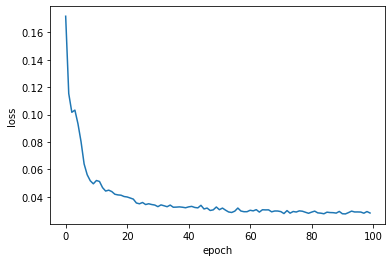

In [13]:
# Training the Model of method 3:

all_losses = []

for i in range(training_steps):
  print('epoch:',i)
  loss = train_step_3()
  if i % display_step == display_step-1:
    print("loss:", loss)
  all_losses.append(loss)

plt.plot(np.arange(0,training_steps),all_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Does not learn with F = F2D(..., 'sinxpy_real') or 'xpy_real' 
- take a look at dF_dx and so on
- ... at the hyperparameters 
- 

## Compare to the true solution

Common to all the methods

In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

np.max(error): 0.03622461


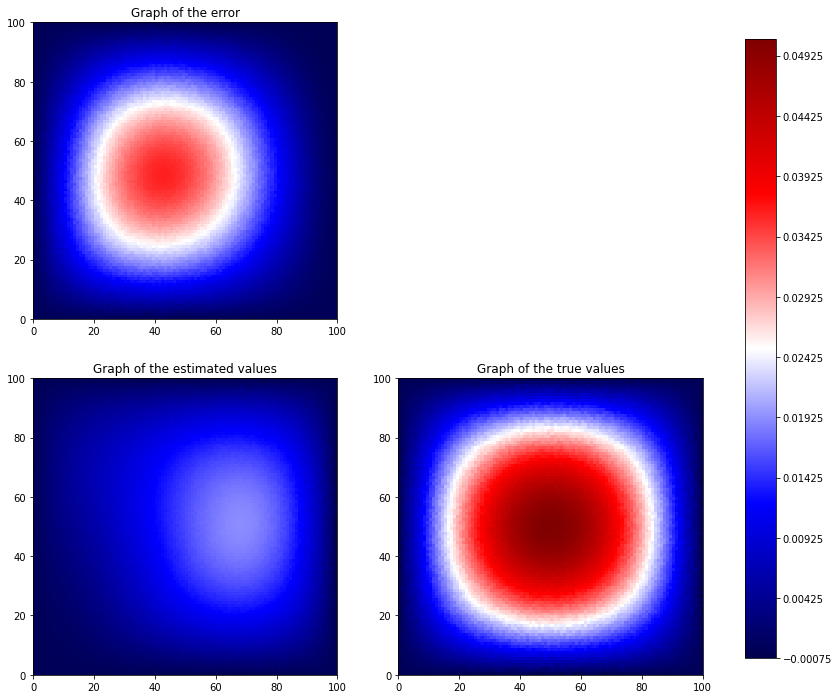

In [77]:
def true_function(X):
    return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])/(2*np.pi**2)

# to check that the model is not overfitting
# Rk: may blur the cmapping then
noise = (tf.random.uniform((grid_length**2,2))-0.5)/grid_length

tf_noisy_coords = tf_coords+noise
true_values = tf.reshape(true_function(tf_noisy_coords),[100,100]).numpy()
appro_values = tf.reshape(g_3(tf_noisy_coords),[100,100]).numpy()            
# change g according to the method applied
# no @tf.function above g_3...
error = np.abs(true_values-appro_values)



print('np.max(error):',np.max(error))
#print(error.shape)

combined_data = [error, appro_values, true_values]
_min,_max = np.min(combined_data), np.max(combined_data)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,12))

seismic = cm.get_cmap('seismic', 1024)

plt.subplot(221)
plt.pcolormesh(error, cmap = seismic,vmin=_min,vmax=_max)
plt.title('Graph of the error')

ax = axes.flat[1]
ax.set_axis_off()

plt.subplot(223)
plt.pcolormesh(appro_values, cmap = seismic,vmin=_min,vmax=_max)
plt.title('Graph of the estimated values')

plt.subplot(224)
im = plt.pcolormesh(true_values, cmap = seismic, vmin=_min,vmax=_max)
plt.title('Graph of the true values')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)

cbar.set_ticks(np.arange(_min,_max+1e-10, 0.5e-2))

Les valeurs sont très petites aux bords. L'écart avec les conditions aux frontières doit être négligé. 

## Save the model

In [1]:
multilayer_perceptron.save('differentiate/savings/model_EDP_2D.h5')

NameError: name 'multilayer_perceptron' is not defined

## Load the model

In [18]:
multilayer_perceptron = keras.models.load_model('differentiate/savings/model_EDP_2D.h5')

# Questions 

Quelle architecture ? 

Comment éviter l'overfitting ?

Comment exploiter les avantages de l'IA ?

Choix de l'optimizer + regularizer ? + Implémentation ?

Implémentation de système d'EDP à plusieurs inconnues (étant des fonctions bien sûr) ? (Est-ce que c'est utile ça ? Par curiosité)

Plus rapide ? Comment enlever les boucles `for` ? => mini_batch_gradient_descent ? done

Besoin de batch_normalization ? + autres hyperparamètres ?

# Idées

Ajout de bruit en entrée contre l'overfitting 

Une sortie par inconnue